<a href="https://colab.research.google.com/github/betogaona7/Grounded-Segment-Anything/blob/main/grounded_sam_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Grounded SAM Inpainting Demo](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

## Why this project?

- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable **to detect and segment everything** with text inputs!



## Install

In [1]:
!ls

assets				  grounded_sam_whisper_inpainting_demo.py
automatic_label_demo.py		  GroundingDINO
automatic_label_ram_demo.py	  grounding_dino_demo.py
automatic_label_simple_demo.py	  groundingdino_swint_ogc.pth
automatic_label_tag2text_demo.py  LICENSE
chatbot.py			  looped_grounded_sam.py
cog.yaml			  looped_grounded_sam_test.py
Dockerfile			  Makefile
EfficientSAM			  playground
gradio_app.py			  predict.py
grounded_sam_3d_box.ipynb	  README.md
grounded_sam_colab_demo.ipynb	  requirements.txt
grounded_sam_demo.py		  sam_vit_h_4b8939.pth
grounded_sam_inpainting_demo.py   sam_vit_h_4b8939.pth.1
grounded_sam.ipynb		  sam_vit_h_4b8939.pth.2
grounded-sam-osx		  segment_anything
grounded_sam_osx_demo.py	  Tag2Text
grounded_sam_simple_demo.py	  VISAM
grounded_sam_visam.py		  voxelnext_3d_box
grounded_sam_whisper_demo.py


In [2]:
#%cd /content

#!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

#%cd Grounded-Segment-Anything 
!pip install -q -r requirements.txt
%cd /home/MichaelWang/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /home/MichaelWang/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /home/MichaelWang/Grounded-Segment-Anything

/home/MichaelWang/Grounded-Segment-Anything/GroundingDINO
/home/MichaelWang/Grounded-Segment-Anything/segment_anything
/home/MichaelWang/Grounded-Segment-Anything


## Imports

In [3]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

/home/MichaelWang/anaconda3/envs/SAM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load models

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Grounding DINO model

In [5]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    args.device = device
    model = build_model(args)
    
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [6]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/home/MichaelWang/anaconda3/envs/SAM/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/MichaelWang/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM 

In [7]:
#! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

### Stable Diffusion (Inpainting)

In [8]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

## Inference

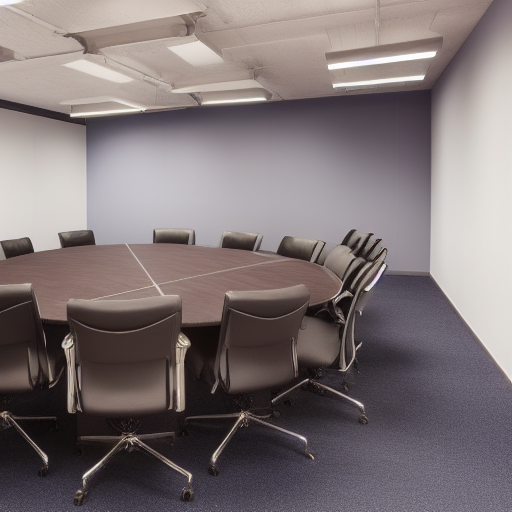

In [9]:
# Load image 
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "/home/MichaelWang/Inpaint_Imgs/conference2/conference2_11.png"
#image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

#download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## Grounding DINO for detection

In [10]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model, 
      image=image, 
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB 
  return annotated_frame, boxes 

/home/MichaelWang/anaconda3/envs/SAM/lib/python3.9/site-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/MichaelWang/anaconda3/envs/SAM/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


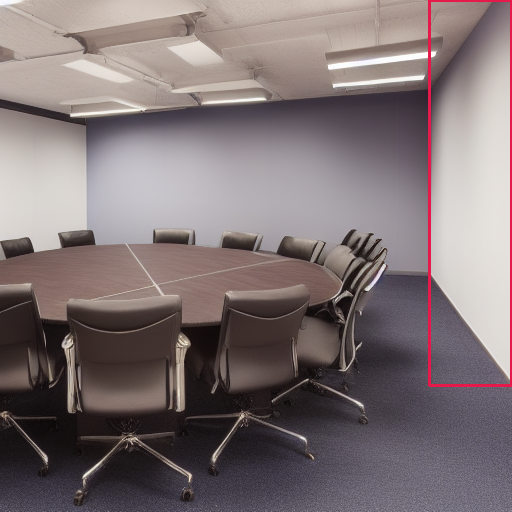

In [11]:
annotated_frame, detected_boxes = detect(image, text_prompt="sidewall", model=groundingdino_model)
Image.fromarray(annotated_frame)

## SAM for segmentation

In [12]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()
  

def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [13]:
print(detected_boxes)
print(detected_boxes.size())


tensor([[0.9196, 0.3768, 0.1605, 0.7517]])
torch.Size([1, 4])


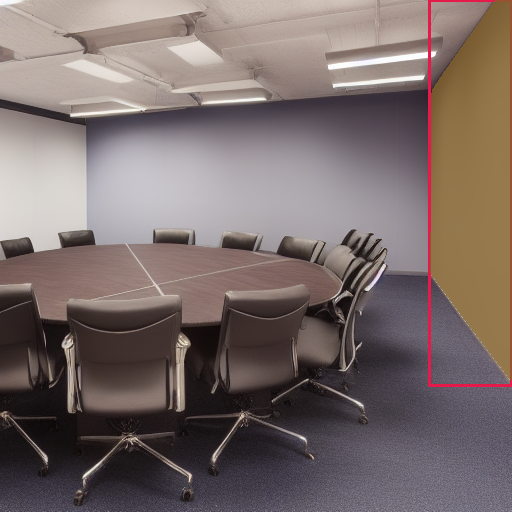

In [14]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

## Stable Diffusion for inpainting

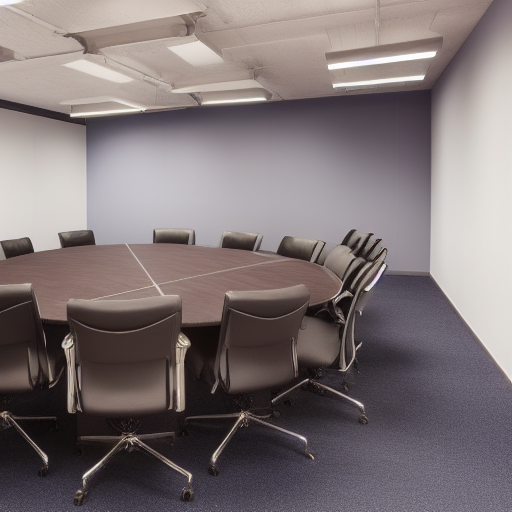

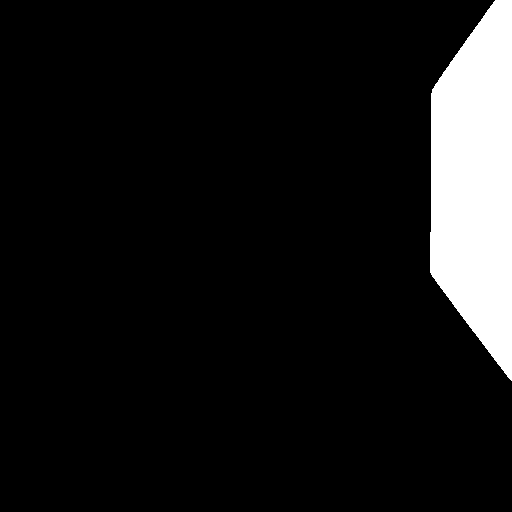

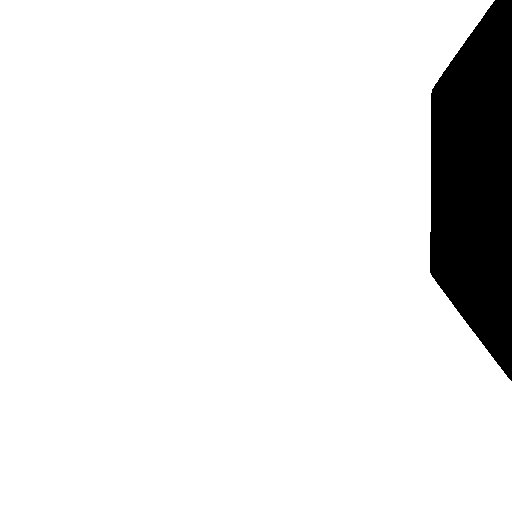

In [15]:
# create mask images 
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

In [26]:
trans10kv2pallete = [
    0, 0, 0,
    120, 120, 70,
    235, 255, 7,
    6, 230, 230,
    204, 255, 4,
    120, 120, 120,
    140, 140, 140,
    255, 51, 7,
    224, 5, 255,
    204, 5, 255,
    150, 5, 61,
    4, 250, 7]

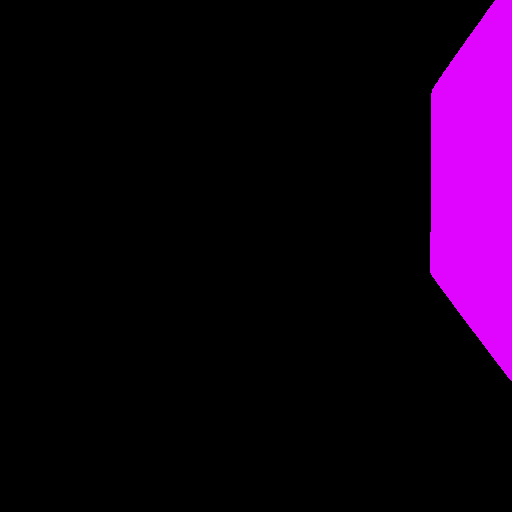

In [28]:
# img_arr = np.asarray(image_mask_pil)
# print(img_arr.shape)
# print(img_arr)
# print(img_arr[img_arr == 1])

image_mask_converted = image_mask_pil.convert("L")
for i in range(0, image_mask_converted.size[0]):
    for j in range(0, image_mask_converted.size[1]):
        if image_mask_converted.getpixel((i, j)) == 255:
            image_mask_converted.putpixel(((i, j)), 8)
image_mask_converted.putpalette(trans10kv2pallete)
display(image_mask_converted)

In [17]:
def generate_image(image, mask, prompt, negative_prompt, pipe): #, seed
  # resize for inpainting 
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  #generator = torch.Generator(device).manual_seed(seed) 

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt) #, generator=generator
  result = result.images[0]

  return result.resize((w, h))

 22%|██▏       | 11/50 [00:00<00:02, 17.89it/s]

100%|██████████| 50/50 [00:02<00:00, 18.27it/s]


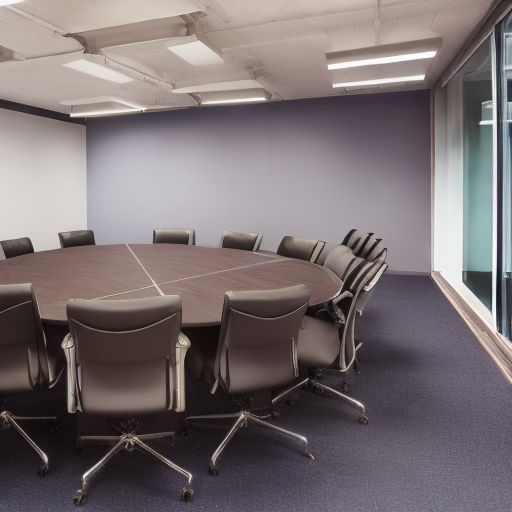

In [18]:
prompt="transparent glass wall                         "
negative_prompt="low resolution, ugly, patterns, design, artistic"
#seed = 32 # for reproducibility 

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe) #, seed=seed
generated_image

In [19]:
prompt="a beach with turquoise water, sand, and coconuts"
negative_prompt="people, low resolution, ugly"
seed = 32 # for reproducibility 

generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
generated_image

TypeError: generate_image() takes 5 positional arguments but 6 were given

: 